In [880]:
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import boxplot 
from sklearn.model_selection import KFold
from vecstack import stacking
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [881]:
# X_train_full = pd.read_csv('../input/train.csv', index_col='Id')
# X_test = pd.read_csv('../input/test.csv', index_col='Id')
# X_train_full = pd.read_csv('/Users/avyny/Documents/Data_analyses-Kaggle/Data_House_Pricing/train.csv', index_col='Id')
# X_test = pd.read_csv('/Users/avyny/Documents/Data_analyses-Kaggle/Data_House_Pricing/test.csv', index_col='Id')
X_train_full = pd.read_csv('D:\\Learning_IT\\Data_analyses-Kaggle\\Data_House_Pricing\\train.csv', index_col='Id')
X_test = pd.read_csv('D:\\Learning_IT\\Data_analyses-Kaggle\\Data_House_Pricing\\test.csv', index_col='Id')


Text(0, 0.5, 'Count')

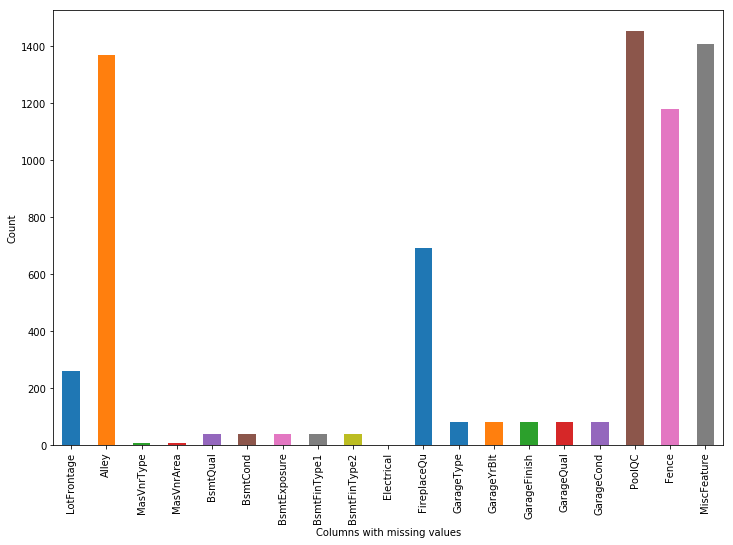

In [882]:
## Detecting of NA
missing_val_count_by_column = (X_train_full.isnull().sum())
missing_val_count_by_column[missing_val_count_by_column > 0]
missing_val_count_by_column[missing_val_count_by_column > 0].plot.bar(figsize=(12,8))
plt.xlabel('Columns with missing values')
plt.ylabel('Count')

In [883]:
## So, a lot of missing values in column 'Alley' - it is better to delete it
# Also I decided to drop 'Utilities' because it's close to constant variable
X_train_full = X_train_full.drop(['Alley', 'Utilities'], axis = 1)
X_test = X_test.drop(['Alley', 'Utilities'], axis = 1)

In [884]:
# Finding the most expencive houses by SalePrice
pd.DataFrame(X_train_full['SalePrice']).sort_values(by = 'SalePrice', ascending = False).head(4)

,SalePrice
Id,
692,755000
1183,745000
1170,625000
899,611657


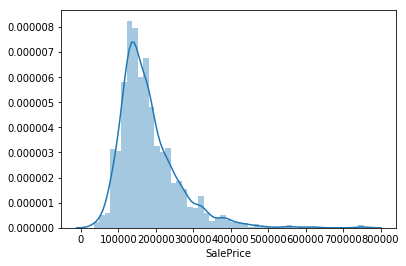

In [885]:
# Density plot for Sale Prices
sns.distplot(X_train_full['SalePrice'])

In [886]:
## Preprocessing data
### Simplifying features
X_train_full['Street'], X_test['Street'] = X_train_full['Street'].map({'Pave': 1, 'Grvl': 0}), X_test['Street'].map({'Pave': 1, 'Grvl': 0})

X_train_full['Condition2'] = X_train_full['Condition2'].apply(lambda z: 1 if z == 'Norm' else 0)
X_test['Condition2'] = X_test['Condition2'].apply(lambda z: 1 if z == 'Norm' else 0)

X_train_full['RoofMatl'] = X_train_full['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Tar&Grv' if x == 'Tar&Grv' else 'Others')
X_test['RoofMatl'] = X_test['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Tar&Grv' if x == 'Tar&Grv' else 'Others')

X_train_full['Heating'] = X_train_full['Heating'].apply(lambda x: 'GasA' if x == 'GasA' else 'GasW' if x == 'GasW' else 'Others')
X_test['Heating'] = X_test['Heating'].apply(lambda x: 'GasA' if x == 'GasA' else 'GasW' if x == 'GasW' else 'Others')

X_train_full['CentralAir'] = X_train_full['CentralAir'].map({'Y': 1, 'N': 0})
X_test['CentralAir'] = X_test['CentralAir'].map({'Y': 1, 'N': 0})

### Filling NA with variables
X_train_full['LotFrontage'] = X_train_full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X_test['LotFrontage'] = X_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

X_test.update(X_test[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea']].fillna(0))
X_train_full.update(X_train_full[['GarageYrBlt', 'MasVnrArea']].fillna(0))

X_train_full.update(X_train_full[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('NoBsmt'))
X_test.update(X_test[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('NoBsmt'))

X_train_full['FireplaceQu'], X_test['FireplaceQu'] = X_train_full['FireplaceQu'].fillna('NoFireplace'), X_test['FireplaceQu'].fillna('NoFireplace')

X_train_full.update(X_train_full[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('NoGarage'))
X_test.update(X_test[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('NoGarage'))

X_train_full['PoolQC'], X_test['PoolQC'] = X_train_full['PoolQC'].fillna('NoPool'), X_test['PoolQC'].fillna('NoPool')
X_train_full['Fence'], X_test['Fence'] = X_train_full['Fence'].fillna('NoFence'), X_test['Fence'].fillna('NoFence')

X_train_full['MiscFeature'], X_test['MiscFeature'] = X_train_full['MiscFeature'].fillna('NoMiscFeature'), X_test['MiscFeature'].fillna('NoMiscFeature')


### Creating additional syntetic variables
X_train_full['Total_amt_bathrooms'] = X_train_full.BsmtFullBath + X_train_full.FullBath + 0.5*X_train_full.BsmtHalfBath + 0.5*X_train_full.HalfBath
X_test['Total_amt_bathrooms'] = X_test.BsmtFullBath + X_test.FullBath + 0.5*X_test.BsmtHalfBath + 0.5*X_test.HalfBath

X_train_full['Total_porch_sf'] = X_train_full.OpenPorchSF + X_train_full.EnclosedPorch + X_train_full['3SsnPorch'] + X_train_full.ScreenPorch
X_test['Total_porch_sf'] = X_test.OpenPorchSF + X_test.EnclosedPorch + X_test['3SsnPorch'] + X_test.ScreenPorch

X_train_full['Remodel_aft_building_years'] = X_train_full.YearRemodAdd - X_train_full.YearBuilt
X_test['Remodel_aft_building_years'] = X_test.YearRemodAdd - X_test.YearBuilt

X_train_full['Total_SF'] = X_train_full.TotalBsmtSF + X_train_full['1stFlrSF'] + X_train_full['2ndFlrSF']
X_test['Total_SF'] = X_test.TotalBsmtSF + X_test['1stFlrSF'] + X_test['2ndFlrSF']

X_train_full['Has2ndFloor'] = X_train_full['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['Has2ndFloor'] = X_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasFireplace'] = X_train_full['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasFireplace'] = X_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasBsmt'] = X_train_full['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasBsmt'] = X_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasGarage'] = X_train_full['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasGarage'] = X_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasPorch'] = X_train_full['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasPorch'] = X_test['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasPool'] = X_train_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasPool'] = X_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasFence'] = X_train_full['Fence'].apply(lambda x: 1 if x != 'NoFence' else 0)
X_test['HasFence'] = X_test['Fence'].apply(lambda x: 1 if x != 'NoFence' else 0)


### Changing dtypes of some columns
X_train_full['GarageYrBlt'], X_test['GarageYrBlt'] = X_train_full['GarageYrBlt'].astype('int64'), X_test['GarageYrBlt'].astype('int64')

X_train_full = X_train_full.drop('YearRemodAdd', axis=1)
X_test = X_test.drop('YearRemodAdd', axis=1)

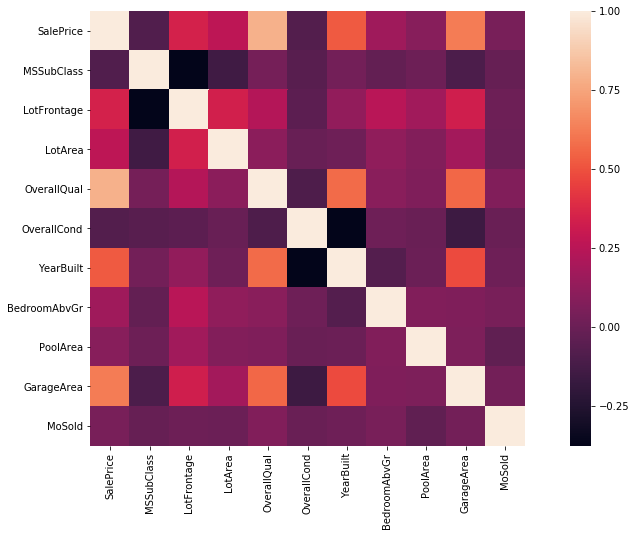

In [887]:
## Correlation between variables
corr_mat = X_train_full[["SalePrice","MSSubClass","MSZoning","LotFrontage","LotArea", "BldgType",
                       "OverallQual", "OverallCond","YearBuilt", "BedroomAbvGr", "PoolArea", "GarageArea",
                       "SaleType", "MoSold"]].corr()

f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr_mat, vmax=1 , square=True)

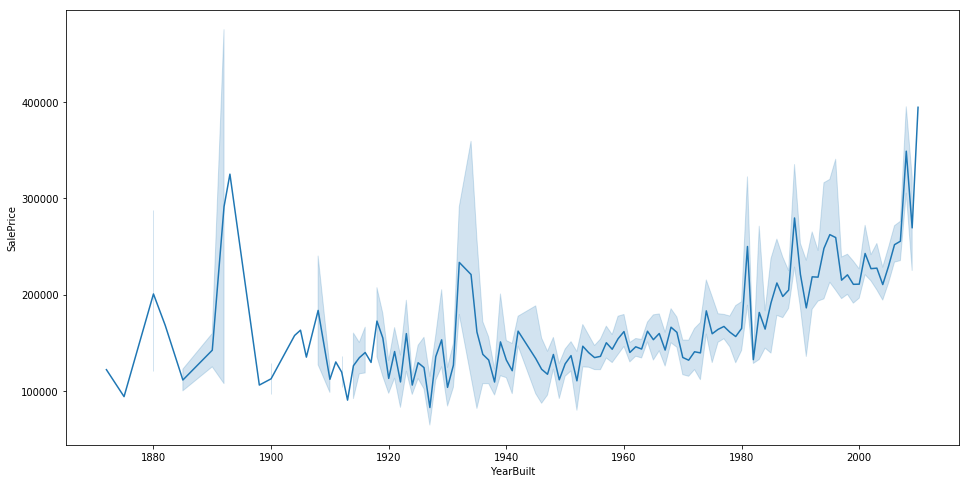

In [888]:
## We can see that SalePrice is the most correlated with OveralQual, YearBuilt and GarageArea, so let's check it's 
## dependecies between each other via plotting.

f, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='YearBuilt', y='SalePrice', data=X_train_full)

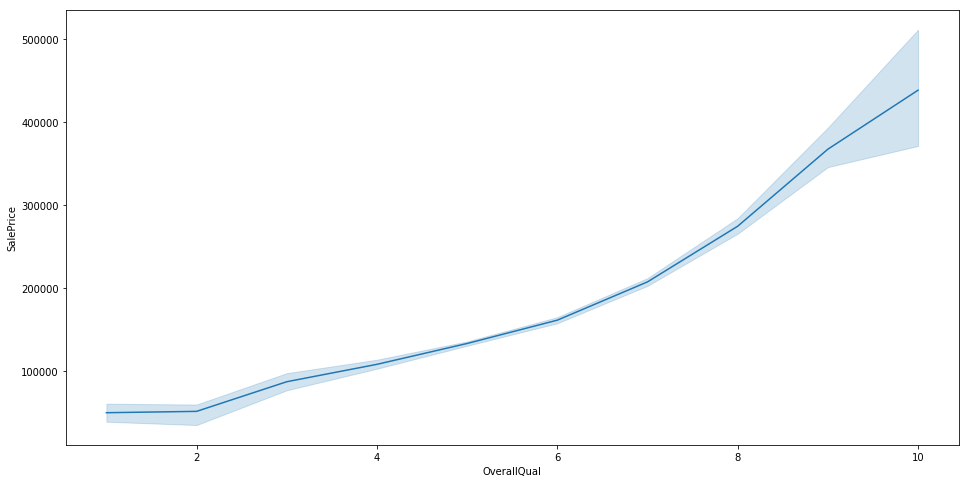

In [889]:
## We can see uptrend in general, but here we can see possible 2 outliers: 2 expencive houses, which was built approx
## in 1890-s and 4 in 1935-s

# POSIIBLE OUTLIES:
    # 186, 584
    # 191, 219, 609, 1269
    
f, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='OverallQual', y='SalePrice', data=X_train_full)

In [890]:
## Here we can see uptrend between Overall Quality of houses and their prices. So it's pretty expectable.

X_train_full.query('YearBuilt < 1900 and OverallQual > 9')


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,Total_porch_sf,Remodel_aft_building_years,Total_SF,Has2ndFloor,HasFireplace,HasBsmt,HasGarage,HasPorch,HasPool,HasFence
Id,,,,,,,,,,,,,,,,,,,,,
186,75,RM,90.0,22950,1,IR2,Lvl,Inside,Gtl,OldTown,...,670,101,4143,1,1,1,1,1,0,1
584,75,RM,75.0,13500,1,Reg,Lvl,Inside,Gtl,OldTown,...,502,107,4012,1,1,1,1,1,0,0


In [891]:
## Separating target value and features
y = X_train_full.SalePrice              
X_train_full.drop(['SalePrice'], axis=1, inplace=True)

In [892]:
## I decided to log variables to make it with normal distribution: 'LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea'
## And the same for target variable

# loged_features = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']
# X_train_full.update(np.log(X_train_full[loged_features]))
# X_test.update(X_test[loged_features])
# y = np.log(y)

In [893]:
## Imputing missing variables with simple imputer for least vars

X_train_full = pd.get_dummies(X_train_full)
X_test = pd.get_dummies(X_test)

si = SimpleImputer(strategy='most_frequent')

X_train_a = pd.DataFrame(si.fit_transform(X_train_full))
X_train_a.columns = X_train_full.columns

X_test_a = pd.DataFrame(si.fit_transform(X_test))
X_test_a.columns = X_test.columns
X_test_a.index = X_test.index

# X_train_a, X_test_a = X_train_a.align(X_test_a, join='left', axis=1)

In [894]:
train_cols = X_train_a.columns
test_cols = X_test_a.columns
common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test
X_train_a = X_train_a.drop(train_not_test, axis=1)

In [895]:
## Deleting possible outliers

# The most expensive SalePrice is obsevations # 692, 1183, 1170, 899 (> 600000)

# Huge 'LotArea' in observations # 314, 336, 250, 707 (> 100000 )
# Huge 'LotFrontage' in observations # 1299, 935, 1128 ( > 180 )
# Huge 'GrLivArea'(общая жилая площадь) # 1299, 524, 1183, 692 ( > 4000 )

y = y.drop([1183, 692], axis = 0)
X_train_a = X_train_a.drop([1183, 692], axis = 0)

# y = y.drop([186, 584], axis = 0)
# X_train_a = X_train_a.drop([186, 584], axis = 0)

In [896]:
## Splitting variables on train//test sizes
X_train, X_valid, y_train, y_valid = train_test_split(X_train_a, y, train_size = 0.8, test_size = 0.2, random_state = 12)

In [897]:
# xgb = XGBRegressor(learning_rate=0.03,
#                          n_estimators=800,
#                          max_depth=3, subsample=0.8,
#                          colsample_bytree=0.8
#                        )

xgb = XGBRegressor(n_estimators = 500, 
                   learning_rate=0.05, 
                   subsample= 0.75, 
                   colsample_bytree = 0.63
                       )


# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
y_pred = cross_val_score(xg_boost, X_train, y_train, cv=kf, n_jobs=-1)
y_pred.mean()

0.8909126478718423

In [898]:
xgb.fit(X_train, y_train)

[22:57:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.63, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.75, verbosity=1)

In [899]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=6,
                                       learning_rate=0.03, 
                                       n_estimators=900,
                                       verbose=-1,
                                       bagging_fraction=0.80,
                                       bagging_freq=4, 
                                       bagging_seed=6,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7
                                    )

# Perform cross-validation to see how well our model does
kf = KFold(n_splits=5)
y_pred = cross_val_score(lightgbm, X_train, y_train, cv=kf)
print(y_pred.mean())

0.8680478956127224


In [900]:
lightgbm.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=4, bagging_seed=6,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2, feature_fraction_seed=7,
       importance_type='split', learning_rate=0.03, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=900, n_jobs=-1, num_leaves=6, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=-1)

In [901]:
g_boost = GradientBoostingRegressor(alpha = 0.9,
                                    learning_rate=0.023,
                                    loss = 'ls',
                                    max_features='sqrt',
                                    n_estimators=900,
                                    subsample=1
                                   )

# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
y_pred = cross_val_score(g_boost, X_train, y_train, cv=kf, n_jobs=-1)
y_pred.mean()

0.882646318924359

In [902]:
g_boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.023, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=900,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

### Stacking models

In [903]:
models = [xg_boost, lightgbm, g_boost]
S_train, S_test = stacking(models,
                           X_train, y_train, X_valid,
                           regression=True,
                           mode='oof_pred_bag',
                           n_folds=5,
                           random_state=25,
                           verbose=2
                          )

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBRegressor]
[22:58:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [16327.52018229]
[22:59:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [15419.97869166]
[23:00:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  2:  [14650.13837849]
[23:00:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  3:  [14963.77238130]
[23:01:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objectiv

In [904]:
# Initialize 2nd level model
xgb_lev2 = XGBRegressor(learning_rate=0.04, 
                        n_estimators=900,
                        max_depth=3,
                        n_jobs=-1,
                        random_state=17
                       )

# xgb_lev2 = XGBRegressor(n_estimators = 500, 
#                    learning_rate=0.05, 
#                    subsample= 0.75, 
#                    colsample_bytree = 0.63
#                        )

# Fit the 2nd level model on the output of level 1
xgb_lev2.fit(S_train, y_train)

[23:03:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.04, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [905]:
stacked_pred = np.log(xgb_lev2.predict(S_test))
xgb_pred = np.log(xgb.predict(X_valid))
lightgbm_pred = np.log(lightgbm.predict(X_valid))
gboost_pred = np.log(g_boost.predict(X_valid))
y_valid = np.log(y_valid)

print("RMSE of Stacked Model: {}".format(np.sqrt(mean_squared_error(y_valid, stacked_pred))))
print("RMSE of XGBoost Model: {}".format(np.sqrt(mean_squared_error(y_valid, xgb_pred))))
print("RMSE of LGBMRegressor: {}".format(np.sqrt(mean_squared_error(y_valid, lightgbm_pred))))
print("RMSE of GradientBoostingRegressor: {}".format(np.sqrt(mean_squared_error(y_valid, gboost_pred))))

RMSE of Stacked Model: 0.14357867779959363
RMSE of XGBoost Model: 0.12391684016006359
RMSE of LGBMRegressor: 0.12846767734512055
RMSE of GradientBoostingRegressor: 0.12328321223376515


#### SO, DEPENDING ON THE BEST SCORE, YOU CAN CHOOSE BEST MODEL, UNCOMMNENT NECESSARY PART FOR SAVING RESULT AND YOU RE WELCOME :)

In [912]:
#### CHECKING MAE, RMSE OF NECESSARY MODEL

predictions = g_boost.predict(X_valid)
# predictions = np.exp(predictions)

mae = mean_absolute_error(np.exp(y_valid), predictions)
print("Mean Absolute Error:" , mae)

rmse = np.sqrt(mean_squared_error(np.log(predictions), y_valid))
print("Root Mean Squared Error:" , rmse)

rmse2 = np.sqrt(mean_squared_error(predictions, np.exp(y_valid)))
print("Root Mean Squared Error:" , rmse2)

Mean Absolute Error: 14803.618421535299
Root Mean Squared Error: 0.12328321223376515
Root Mean Squared Error: 26510.68391967254


In [914]:
#### SAVING RESULT FOR 1 CHOSEN MODEL

preds_test = xgb.predict(X_test_a)
# # preds_test = np.exp(preds_test)
output = pd.DataFrame({'Id': X_test_a.index,
                       'SalePrice': preds_test})
output.to_csv('submissionModel.csv', index=False)
preds_test

array([125519.42 , 159043.16 , 187917.7  , ..., 156145.06 , 121931.695,
       195804.67 ], dtype=float32)

In [909]:
### PREDICTING TEST VALUE BY STACKED MODEL

# y1_pred_L1 = models[0].predict(X_test_a)
# y2_pred_L1 = models[1].predict(X_test_a)
# y3_pred_L1 = models[2].predict(X_test_a)
# S_test_L1 = np.c_[y1_pred_L1, y2_pred_L1, y3_pred_L1]
# preds_test = xgb_lev2.predict(S_test_L1)
# preds_test = np.exp(preds_test)
# output = pd.DataFrame({'Id': X_test_a.index,
#                        'SalePrice': preds_test})
# output.to_csv('submissionStacked.csv', index=False)
# preds_test

array([109331.234, 142859.34 , 160699.34 , ..., 138767.2  , 107223.19 ,
       187537.47 ], dtype=float32)

In [910]:

## + TOP2 SCORE Model Configuration (without logariphm) outliers: 1183, 692
# model = XGBRegressor(n_estimators = 500, learning_rate=0.05, subsample= 0.75, colsample_bytree = 0.63)
# Mean Absolute Error: 14445.85 Root Mean Squared Error: 0.12315 Root Mean Squared Error: 27694.38
# SCORE1 = 14351, SCORE2 = 0.12542
